In [2]:
import pandas as pd

# 載入數據
df = pd.read_excel(r'/Users/tangjiahong/Dropbox/Movie/鄭伊廷/台灣國片長片資料.xlsx')


In [8]:
import pandas as pd
import statsmodels.formula.api as smf

# 假設 df 是你的 DataFrame，其中包含所有需要的變量
# 重命名包含非法字符的變數
df.rename(columns={'Class_#N/A': 'Class_NA'}, inplace=True)

# 設置面板數據格式
df['year'] = df['PlayYear']
df['id'] = df['MovieID']

# 定義公式，增加更多控制變數
formula = (
    'Audience ~ IMDb_rating + Tempture + Rainfall + No_Weather + '
    'PlayWeek + Weekend + Play_nWeek + ViewDay + CutBack + GHA_View_Code + TFF_View_Code + '
    'Theater_Class + MovieFest + Rated + Class_Darma + Class_Comedy + Class_Action + '
    'Class_Documentary + Class_Animation + Class_Other + Class_NA + Movie_Length + '
    'Director_Award + Producer_Famous + Distrbutor + Budget + Actor_Awardall + '
    'Subsidy_Amount + Subsidy_Yes + Oscar_Nom + Oscar_AwardTotal + Cannes_Nom + '
    'Cannes_AwardTotal + GHA_Nom + GHA_AwardTotal + TFF_Nom + TFF_AwardTotal + '
    'TFF_NomData + view_afhorse + view_aftaipei + year_2018 + year_2019 + year_2020 + '
    'year_2021 + year_2022 + month_2 + month_3 + month_4 + month_5 + month_6 + month_7 + '
    'month_8 + month_9 + month_10 + month_11 + month_12 + view_week_1 + view_week_2 + '
    'view_week_3 + view_week_4 + view_week_58 + view_week_912 + theater_1 + theater_2 + '
    'theater_3 + theater_4 + rate_1 + rate_2 + rate_3 + rate_4 + distributor_1 + '
    'distributor_2 + distributor_3 + lnsubsidy + lnbudget + C(year) + C(id)'
)

# 構建固定效應模型並使用穩健標準誤
fixed_effects_model = smf.ols(formula, data=df).fit(cov_type='HC3')

# 查看模型摘要
print(fixed_effects_model.summary())


                            OLS Regression Results                            
Dep. Variable:               Audience   R-squared:                       0.297
Model:                            OLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                     41.23
Date:                Thu, 23 May 2024   Prob (F-statistic):               0.00
Time:                        16:07:49   Log-Likelihood:            -4.7572e+05
No. Observations:               74232   AIC:                         9.523e+05
Df Residuals:                   73819   BIC:                         9.561e+05
Df Model:                         412                                         
Covariance Type:                  HC3                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            36.2152   5501.68

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 454, but rank is 389
  warnings.warn('covariance of constraints does not have full '


In [ ]:
# 假設你關心的變量名稱為'target'
correlation = df.corr().abs()['target'].sort_values(ascending=False)

# 排除與自身的相關性
top_10_correlations = correlation[1:11]  # 排除第一個，因為第一個是自己


            Variable  Correlation Target_Variable
0            ViewDay     0.495039     view_week_1
1       view_week_58     0.272353     view_week_1
2        view_week_2     0.264707     view_week_1
3        view_week_3     0.233054     view_week_1
4        view_week_4     0.192007     view_week_1
..               ...          ...             ...
5   Oscar_AwardTotal     0.149085        lnbudget
6          Oscar_Nom     0.149085        lnbudget
7           No_Oscar     0.149085        lnbudget
8       Class_Action     0.133649        lnbudget
9    Producer_Famous     0.119034        lnbudget

[140 rows x 3 columns]


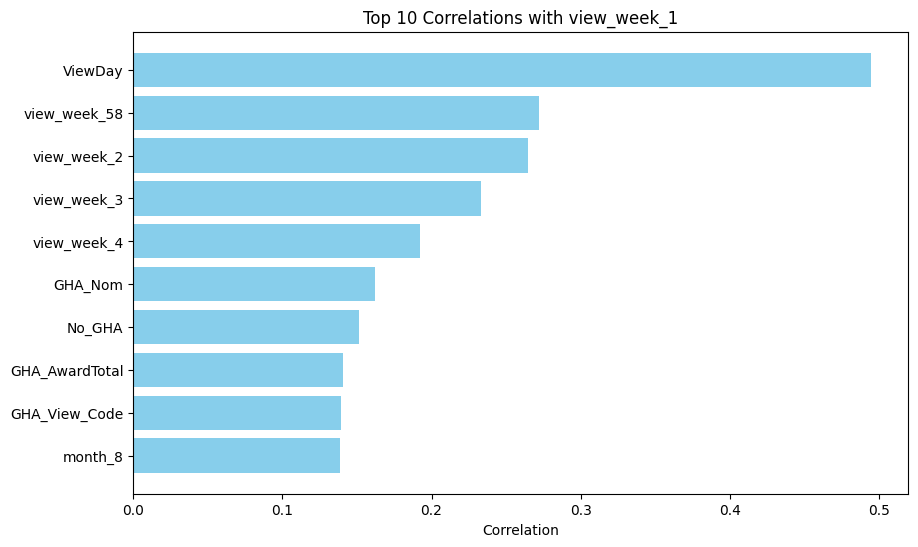

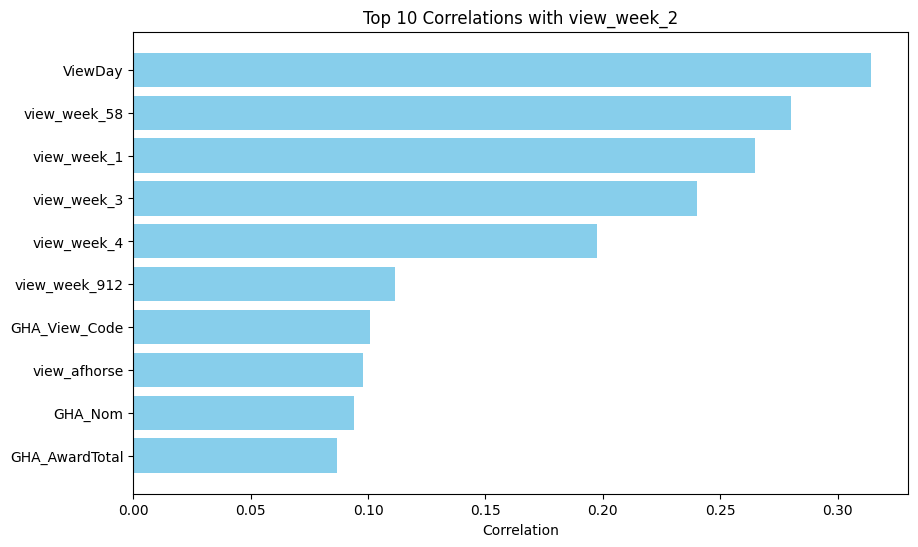

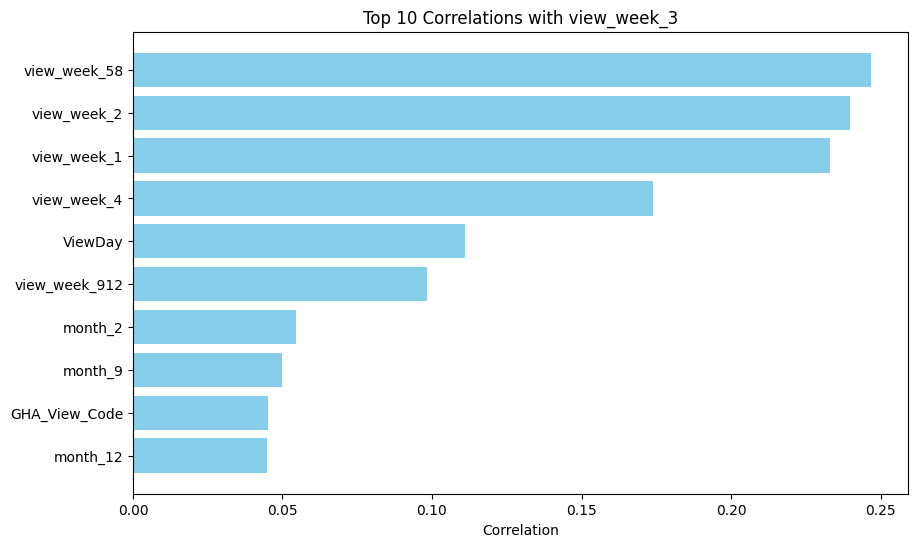

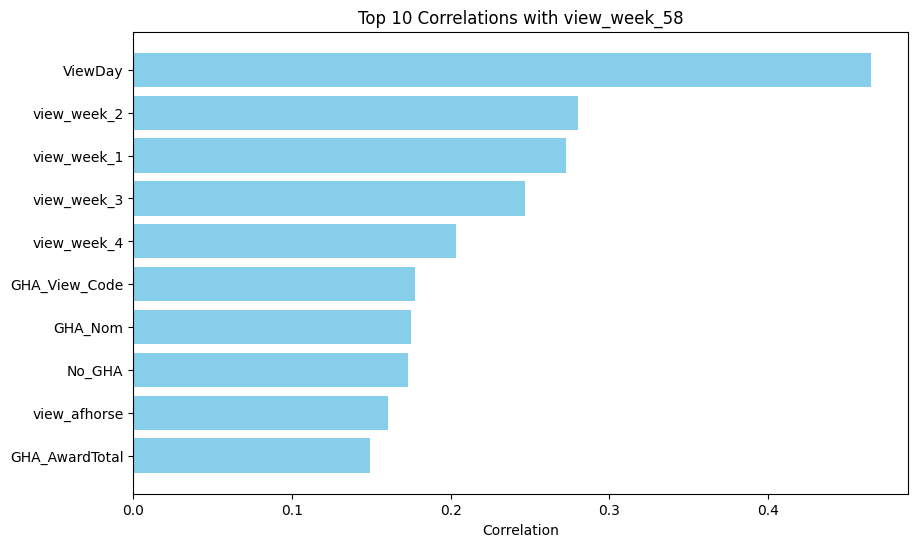

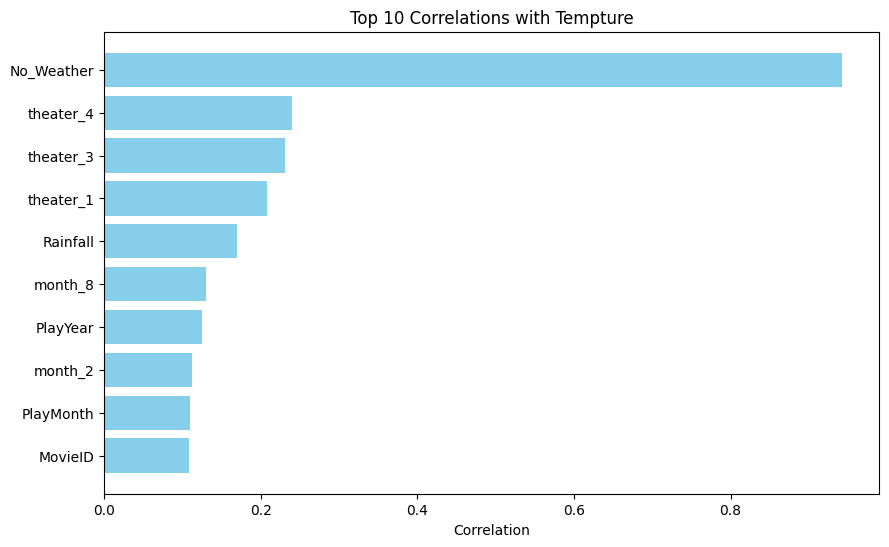

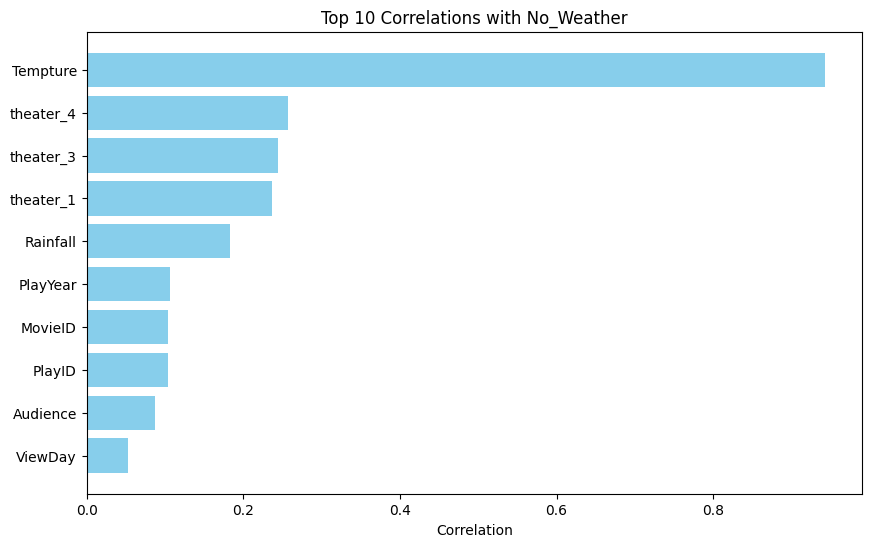

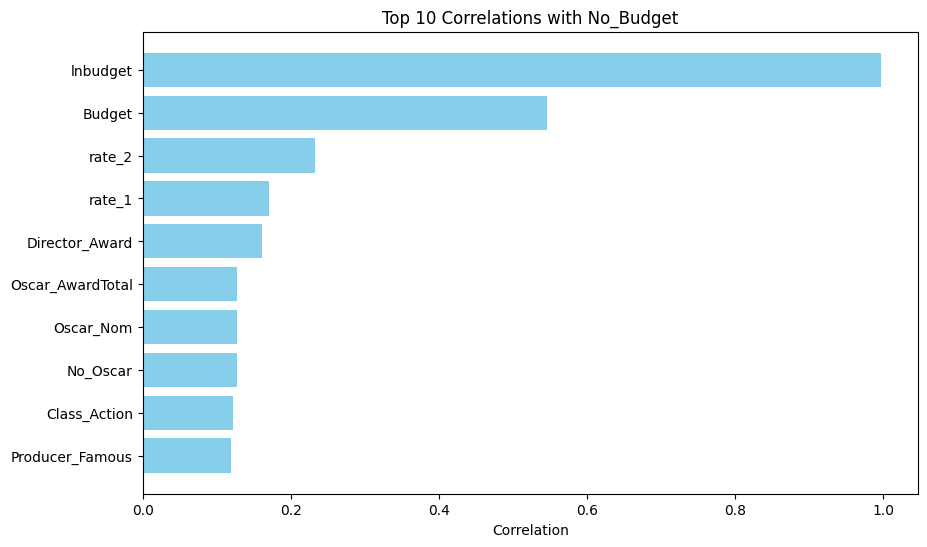

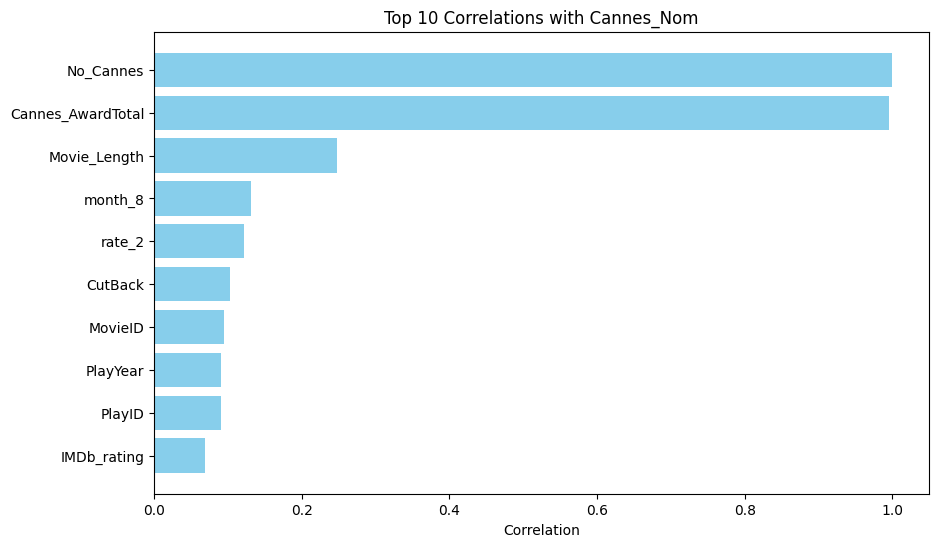

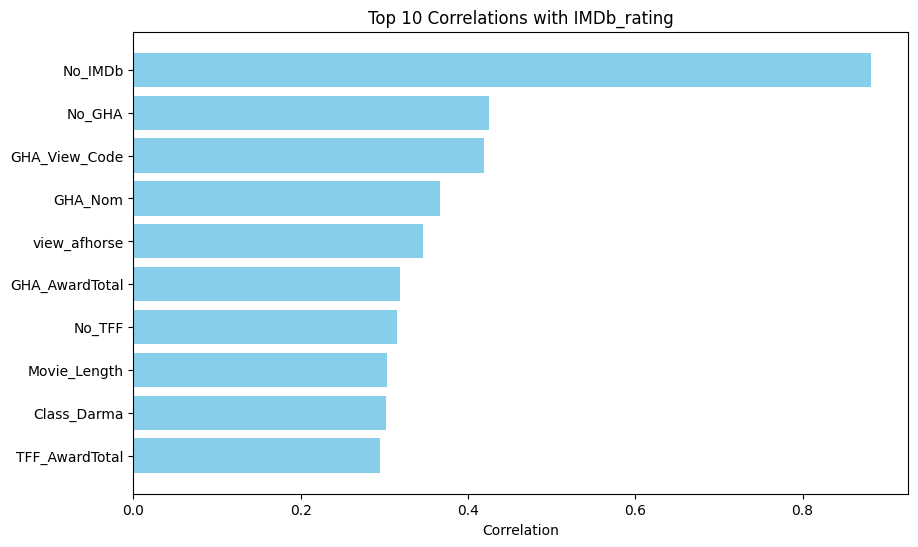

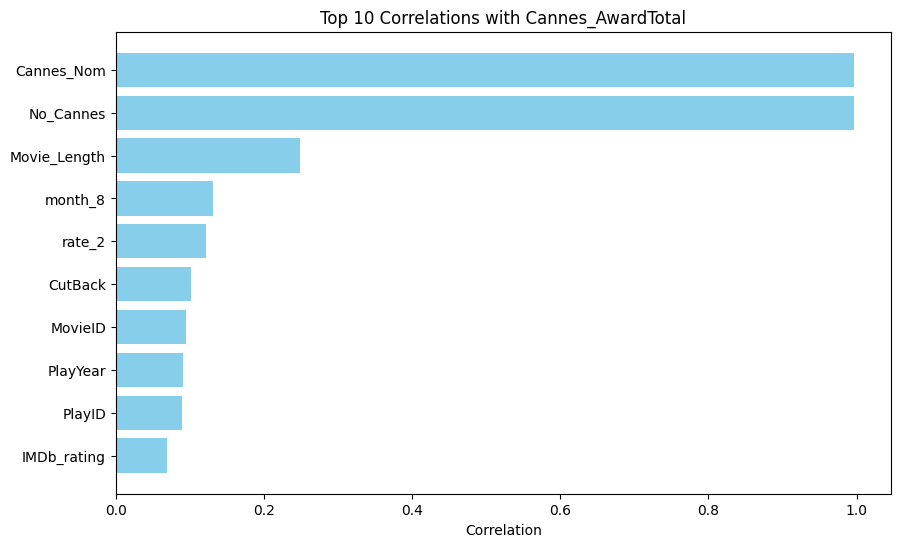

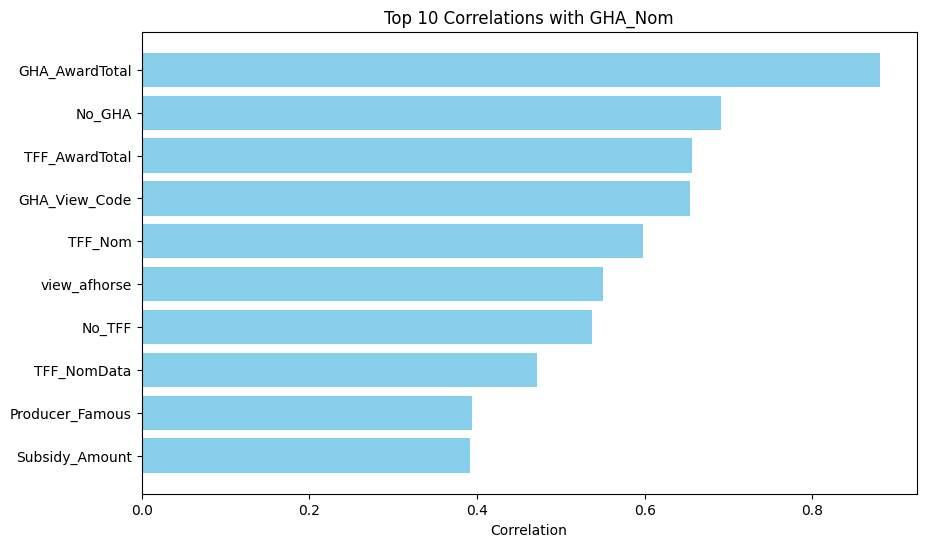

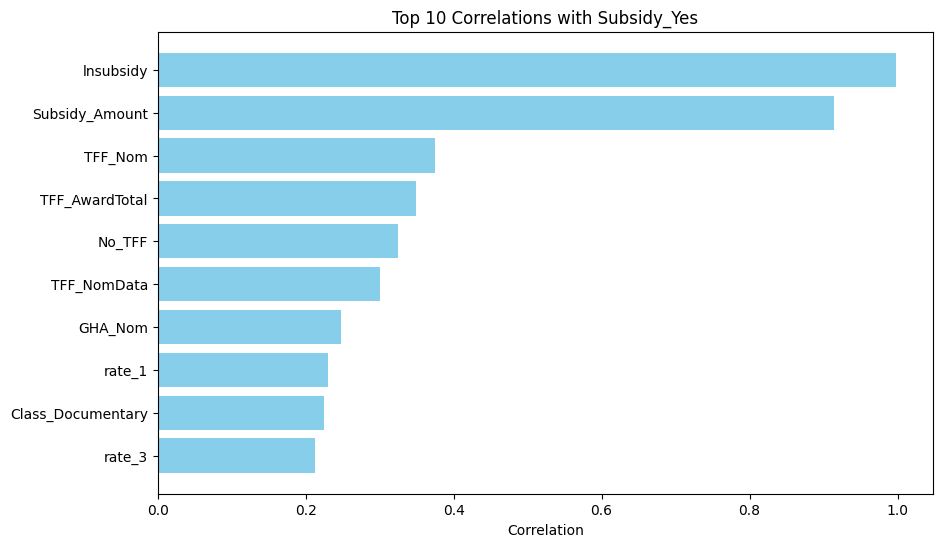

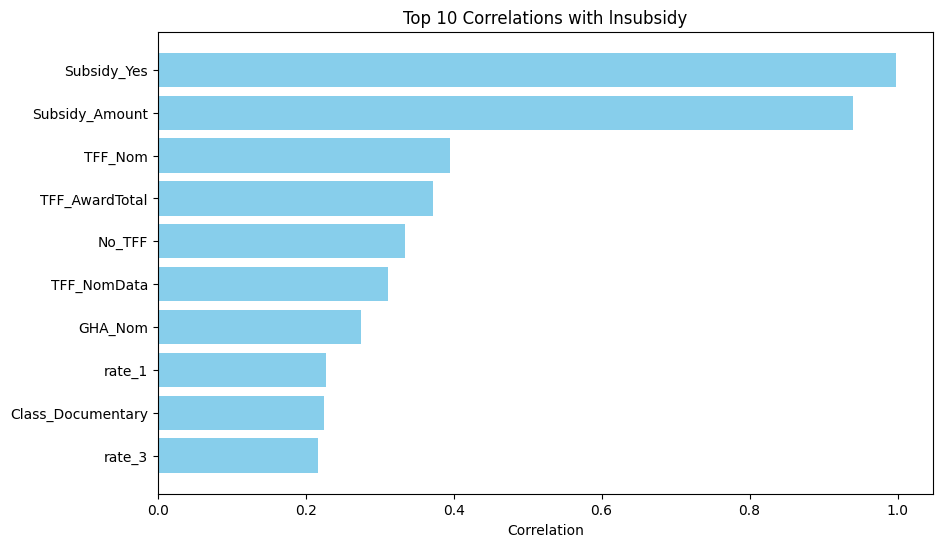

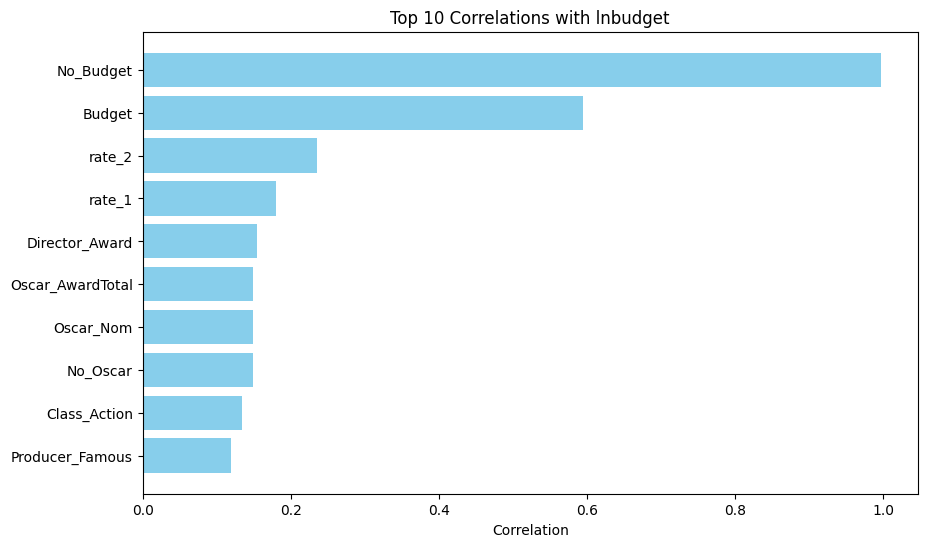

In [7]:
import matplotlib.pyplot as plt

# VIF>10的變數列表
variables_vif_gt_10 = [
    'view_week_1', 'view_week_2', 'view_week_3', 'view_week_58',
    'Tempture', 'No_Weather', 'No_Budget', 'Cannes_Nom','IMDb_rating',
    'Cannes_AwardTotal', 'GHA_Nom', 'Subsidy_Yes', 'lnsubsidy', 'lnbudget'
]

# 計算相關係數
correlation_matrix = df.corr().abs()

# 創建一個空的DataFrame來存儲結果
top_10_corr_df_list = []

for variable in variables_vif_gt_10:
    # 排除自身的相關性，並找到前十個最高相關性變數
    top_10_corr = correlation_matrix[variable].drop(labels=[variable]).nlargest(10)
    top_10_corr_df = pd.DataFrame(top_10_corr).reset_index()
    top_10_corr_df.columns = ['Variable', 'Correlation']
    top_10_corr_df['Target_Variable'] = variable
    top_10_corr_df_list.append(top_10_corr_df)

# 合併所有結果到一個DataFrame
final_corr_df = pd.concat(top_10_corr_df_list)

# 將結果表格顯示
print(final_corr_df)

# 將結果保存到Excel文件
final_corr_df.to_excel('top_10_correlations.xlsx', index=False)

# 繪製圖表
for variable in variables_vif_gt_10:
    plt.figure(figsize=(10, 6))
    subset_df = final_corr_df[final_corr_df['Target_Variable'] == variable]
    plt.barh(subset_df['Variable'], subset_df['Correlation'], color='skyblue')
    plt.xlabel('Correlation')
    plt.title(f'Top 10 Correlations with {variable}')
    plt.gca().invert_yaxis()  # 反轉Y軸，讓最高相關性在最上面
    plt.show()


In [5]:
# 創建一個空的集合來存儲共同值
common_values = None

# 迭代變數，找到交集
for variable in variables:
    if common_values is None:
        common_values = set(df[variable])
    else:
        common_values = common_values.intersection(set(df[variable]))

# 將共同值轉換為DataFrame並顯示
common_values_df = pd.DataFrame(list(common_values), columns=['Common Values'])
print(common_values_df)

   Common Values
0              0


               view_week_1  view_week_2  view_week_3  view_week_4  \
view_week_1       1.000000    -0.264707    -0.233054    -0.192007   
view_week_2      -0.264707     1.000000    -0.239907    -0.197652   
view_week_3      -0.233054    -0.239907     1.000000    -0.174017   
view_week_4      -0.192007    -0.197652    -0.174017     1.000000   
view_week_58     -0.272353    -0.280361    -0.246836    -0.203361   
view_week_912    -0.108402    -0.111590    -0.098246    -0.080942   

               view_week_58  view_week_912  
view_week_1       -0.272353      -0.108402  
view_week_2       -0.280361      -0.111590  
view_week_3       -0.246836      -0.098246  
view_week_4       -0.203361      -0.080942  
view_week_58       1.000000      -0.114813  
view_week_912     -0.114813       1.000000  
        Variable        VIF
1    view_week_1  12.453893
2    view_week_2  12.843813
3    view_week_3  11.141808
4    view_week_4   8.732586
5   view_week_58  13.226267
6  view_week_912   3.950734


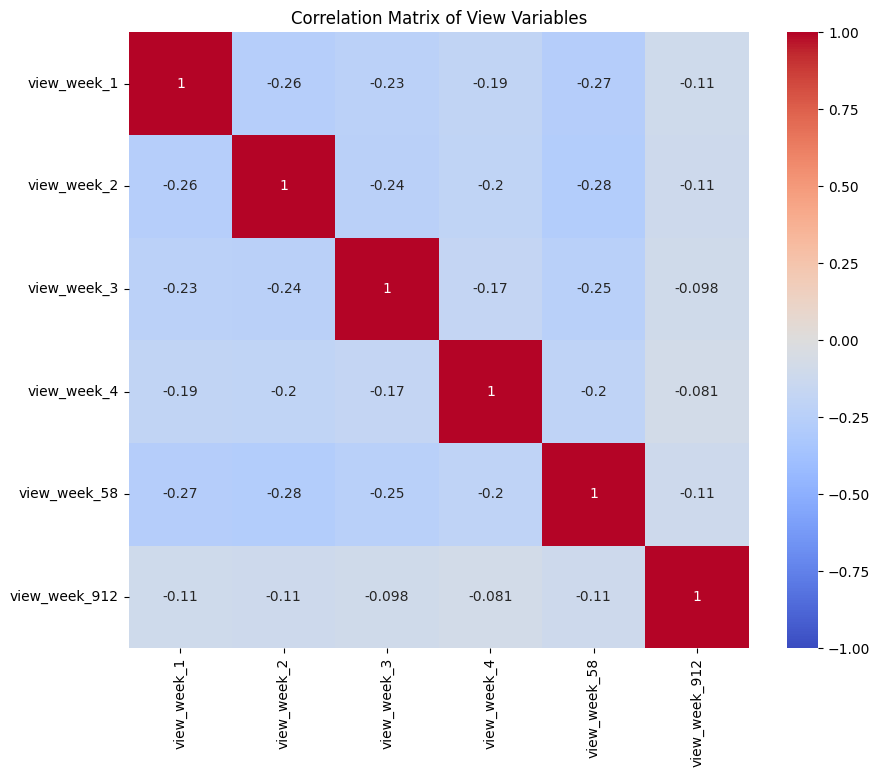

/var/folders/td/m175xz391hd4h1j11qwz0vyc0000gn/T/ipykernel_91722/1844392277.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='VIF', y='Variable', data=vif_df, palette='viridis')


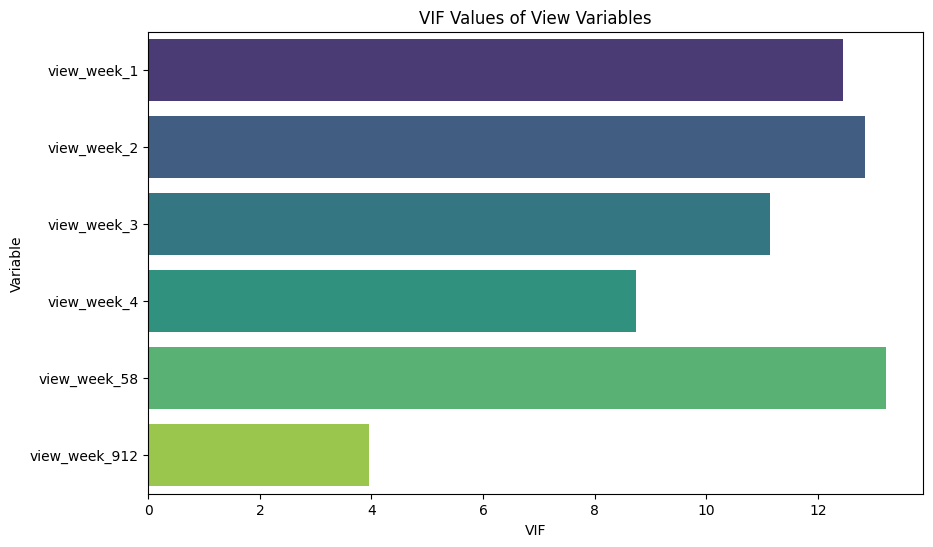

In [6]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 指定的虛擬變數列表
variables = ['view_week_1', 'view_week_2', 'view_week_3', 'view_week_4', 'view_week_58', 'view_week_912']

# 計算相關性矩陣
correlation_matrix = df[variables].corr()
print(correlation_matrix)

# 計算VIF值
X = df[variables].dropna()  # 確保數據中沒有NaN值
X = sm.add_constant(X)  # 添加常數項
vif_df = pd.DataFrame()
vif_df['Variable'] = X.columns
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_df = vif_df[vif_df['Variable'] != 'const']  # 移除常數項
print(vif_df)

# 可視化相關性矩陣
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of View Variables')
plt.show()

# 可視化VIF值
plt.figure(figsize=(10, 6))
sns.barplot(x='VIF', y='Variable', data=vif_df, palette='viridis')
plt.title('VIF Values of View Variables')
plt.show()
